In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
#Cargar todos los datasets pre-procesados
df_train = pd.read_csv('processed_files/train_md.csv')
df_demografico = pd.read_csv('processed_files/demografica.csv')
#df_mod_existentes = pd.read_csv('processed_files/modelos_existentes.csv')
df_historic = pd.read_csv('processed_files/historic.csv')

In [3]:
df_train.describe()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,min_mora,max_mora,dias_mora_fin,vlr_obligacion,vlr_vencido,saldo_capital,endeudamiento,cant_alter_posibles,cant_gestiones,cant_gestiones_binario,rpc,promesas_cumplidas,cant_promesas_cumplidas_binario,cant_acuerdo,cant_acuerdo_binario,valor_cuota_mes,pago_cuota,porc_pago_cuota,pago_mes
count,568251.000000,5.682510e+05,5.682510e+05,568251.000000,568251.000000,568251.000000,568251.000000,568251.000000,5.682510e+05,5.682510e+05,5.682510e+05,5.682510e+05,568251.000000,568251.000000,568251.000000,568251.000000,568251.000000,568251.000000,568251.000000,568251.000000,5.682510e+05,5.682510e+05,568251.000000,5.682510e+05
mean,307451.784203,5.359492e+05,5.435817e+05,202309.946909,0.480013,26.847504,48.543566,37.255445,1.166472e+07,1.036970e+06,1.080523e+07,3.532702e+07,1.810911,33.347179,0.967358,0.933244,0.211181,0.095718,1.076658,0.304798,1.009573e+06,8.378919e+05,0.238374,2.235457e+05
std,182473.928544,3.113386e+05,3.103269e+05,1.386705,0.499601,25.841082,32.154424,35.215980,2.478713e+07,2.722675e+06,2.345022e+07,5.746192e+07,0.864228,26.653607,0.177699,0.249599,0.689451,0.294205,2.113802,0.460322,2.780314e+06,7.176185e+06,0.406320,1.764742e+06
min,1.000000,4.030000e+02,3.000000e+00,202308.000000,0.000000,1.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,152582.000000,2.680965e+05,2.779360e+05,202309.000000,0.000000,4.000000,23.000000,0.000000,1.577906e+06,1.900590e+05,1.415149e+06,5.103892e+06,1.000000,14.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.833815e+05,0.000000e+00,0.000000,0.000000e+00
50%,299397.000000,5.342080e+05,5.461340e+05,202310.000000,0.000000,17.000000,43.000000,29.000000,4.168354e+06,4.541250e+05,3.773916e+06,1.484568e+07,2.000000,28.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.513657e+05,0.000000e+00,0.000000,0.000000e+00
75%,463424.500000,8.024060e+05,8.110760e+05,202311.000000,1.000000,46.000000,70.000000,60.000000,1.081424e+07,1.032518e+06,9.890030e+06,4.225977e+07,3.000000,44.000000,1.000000,1.000000,0.000000,0.000000,2.000000,1.000000,1.028775e+06,8.586800e+04,0.323465,0.000000e+00
max,634709.000000,1.080339e+06,1.080719e+06,202312.000000,1.000000,90.000000,1612.000000,609.000000,1.589994e+09,5.023519e+08,1.552838e+09,1.879460e+09,12.000000,1030.000000,1.000000,1.000000,16.000000,1.000000,56.000000,1.000000,5.023519e+08,2.415000e+09,1.000000,3.450000e+08


In [3]:
# agregamos las features demograficas de ingresos y patrimonio a la tabla de entrenamiento

df_resultado = df_train.merge(
    df_demografico[['nit_enmascarado', 'total_ing', 'tot_patrimonio']],
    on='nit_enmascarado',
    how='left'
)

nuevas_columnas = ['total_ing', 'tot_patrimonio']
columnas_agregadas = all(col in df_resultado.columns for col in nuevas_columnas)
    
if columnas_agregadas:
    print("Las columnas 'total_ing' y 'tot_patrimonio' se han agregado correctamente.")
else:
    print("Hubo un problema al agregar las nuevas columnas.")

nulos = df_resultado[nuevas_columnas].isnull().sum()
print("\nCantidad de valores nulos en las nuevas columnas:")
print(nulos)

Las columnas 'total_ing' y 'tot_patrimonio' se han agregado correctamente.

Cantidad de valores nulos en las nuevas columnas:
total_ing         111961
tot_patrimonio    111961
dtype: int64


In [5]:
# verificar si los nit_enmascarado en df_train existen en df_demografico

nits_train = df_train['nit_enmascarado'].unique()
nits_demografico = df_demografico['nit_enmascarado'].unique()
nits_no_existen = set(nits_train) - set(nits_demografico)
cantidad_nits_no_existen = len(nits_no_existen)

print(f"Cantidad de nit_enmascarado en df_train que no existen en df_demografico: {cantidad_nits_no_existen}")


Cantidad de nit_enmascarado en df_train que no existen en df_demografico: 52677


In [6]:
features_a_promediar = ['prob_propension', 'prob_alrt_temprana', 'prob_auto_cura']
df_promedios = df_mod_existentes.groupby('nit_enmascarado')[features_a_promediar].mean()

df_promedios.columns = [f'promedio_{col}' for col in df_promedios.columns]

df_resultado = pd.merge(df_resultado, df_promedios, on='nit_enmascarado', how='left')

nuevas_columnas = [f'promedio_{col}' for col in features_a_promediar]
columnas_agregadas = all(col in df_resultado.columns for col in nuevas_columnas)

if columnas_agregadas:
    print("Las columnas de promedios se han agregado correctamente.")
else:
    print("Hubo un problema al agregar las nuevas columnas de promedios.")

# Verificar si hay valores nulos en las nuevas columnas
nulos = df_resultado[nuevas_columnas].isnull().sum()
print("\nCantidad de valores nulos en las nuevas columnas:")
print(nulos)

Las columnas de promedios se han agregado correctamente.

Cantidad de valores nulos en las nuevas columnas:
promedio_prob_propension       24
promedio_prob_alrt_temprana    24
promedio_prob_auto_cura        24
dtype: int64


In [7]:
nits_train = df_resultado['nit_enmascarado'].unique()
nits_mod_existentes = df_mod_existentes['nit_enmascarado'].unique()
nits_no_existen = set(nits_train) - set(nits_mod_existentes)
cantidad_nits_no_existen = len(nits_no_existen)

print(f"Cantidad de nit_enmascarado en df_train que no existen en df_mod_existentes: {cantidad_nits_no_existen}")

Cantidad de nit_enmascarado en df_train que no existen en df_mod_existentes: 11


In [4]:

# Calcular la moda de 'marca_pago' para cada combinación de 'nit_enmascarado' y 'num_oblig_enmascarado'
df_moda = df_historic.groupby(['nit_enmascarado', 'num_oblig_enmascarado'])['marca_pago'].agg(
    lambda x: x.mode().iloc[0] if not x.empty else pd.NA
).reset_index()

df_moda = df_moda.rename(columns={'marca_pago': 'moda_marca_pago'})

df_resultado = pd.merge(
    df_resultado, 
    df_moda, 
    on=['nit_enmascarado', 'num_oblig_enmascarado'], 
    how='left'
)

if 'moda_marca_pago' in df_resultado.columns:
    print("La columna 'moda_marca_pago' se ha agregado correctamente.")
else:
    print("Hubo un problema al agregar la columna 'moda_marca_pago'.")

# Verificar si hay valores nulos en la nueva columna
nulos = df_resultado['moda_marca_pago'].isnull().sum()
print(f"\nCantidad de valores nulos en 'moda_marca_pago': {nulos}")

La columna 'moda_marca_pago' se ha agregado correctamente.

Cantidad de valores nulos en 'moda_marca_pago': 14


In [9]:
df_resultado[['total_ing','tot_patrimonio', 'promedio_prob_propension', 'promedio_prob_alrt_temprana','promedio_prob_auto_cura']].describe()

,total_ing,tot_patrimonio,promedio_prob_propension,promedio_prob_alrt_temprana,promedio_prob_auto_cura
count,8.131850e+05,8.131850e+05,925122.000000,925122.000000,925122.000000
mean,3.976039e+07,1.782410e+08,0.678777,0.449077,0.467521
std,8.104119e+09,2.298601e+10,0.146471,0.149709,0.163752
min,0.000000e+00,0.000000e+00,0.059368,0.039859,0.053027
25%,1.100000e+06,3.901000e+06,0.587051,0.339575,0.334341
50%,2.000000e+06,2.519398e+07,0.706655,0.458228,0.464964
75%,4.538465e+06,8.523100e+07,0.790258,0.558842,0.597604
max,5.800001e+12,9.799656e+12,0.956808,0.923734,0.922523


In [5]:
# Imputación con la mediana para `total_ing` y `tot_patrimonio`
df_resultado['total_ing'] = df_resultado['total_ing'].fillna(df_resultado['total_ing'].median())
df_resultado['tot_patrimonio'] = df_resultado['tot_patrimonio'].fillna(df_resultado['tot_patrimonio'].median())

# Imputación con la media para `promedio_prob_propension`, `promedio_prob_alrt_temprana`, `promedio_prob_auto_cura`
#df_resultado['promedio_prob_propension'] = df_resultado['promedio_prob_propension'].fillna(df_resultado['promedio_prob_propension'].mean())
#df_resultado['promedio_prob_alrt_temprana'] = df_resultado['promedio_prob_alrt_temprana'].fillna(df_resultado['promedio_prob_alrt_temprana'].mean())
#df_resultado['promedio_prob_auto_cura'] = df_resultado['promedio_prob_auto_cura'].fillna(df_resultado['promedio_prob_auto_cura'].mean())


array([[<Axes: title={'center': 'nit_enmascarado'}>,
        <Axes: title={'center': 'num_oblig_orig_enmascarado'}>,
        <Axes: title={'center': 'num_oblig_enmascarado'}>,
        <Axes: title={'center': 'fecha_var_rpta_alt'}>,
        <Axes: title={'center': 'var_rpta_alt'}>],
       [<Axes: title={'center': 'min_mora'}>,
        <Axes: title={'center': 'max_mora'}>,
        <Axes: title={'center': 'dias_mora_fin'}>,
        <Axes: title={'center': 'vlr_obligacion'}>,
        <Axes: title={'center': 'vlr_vencido'}>],
       [<Axes: title={'center': 'saldo_capital'}>,
        <Axes: title={'center': 'endeudamiento'}>,
        <Axes: title={'center': 'cant_alter_posibles'}>,
        <Axes: title={'center': 'cant_gestiones'}>,
        <Axes: title={'center': 'cant_gestiones_binario'}>],
       [<Axes: title={'center': 'rpc'}>,
        <Axes: title={'center': 'promesas_cumplidas'}>,
        <Axes: title={'center': 'cant_promesas_cumplidas_binario'}>,
        <Axes: title={'center': 'c

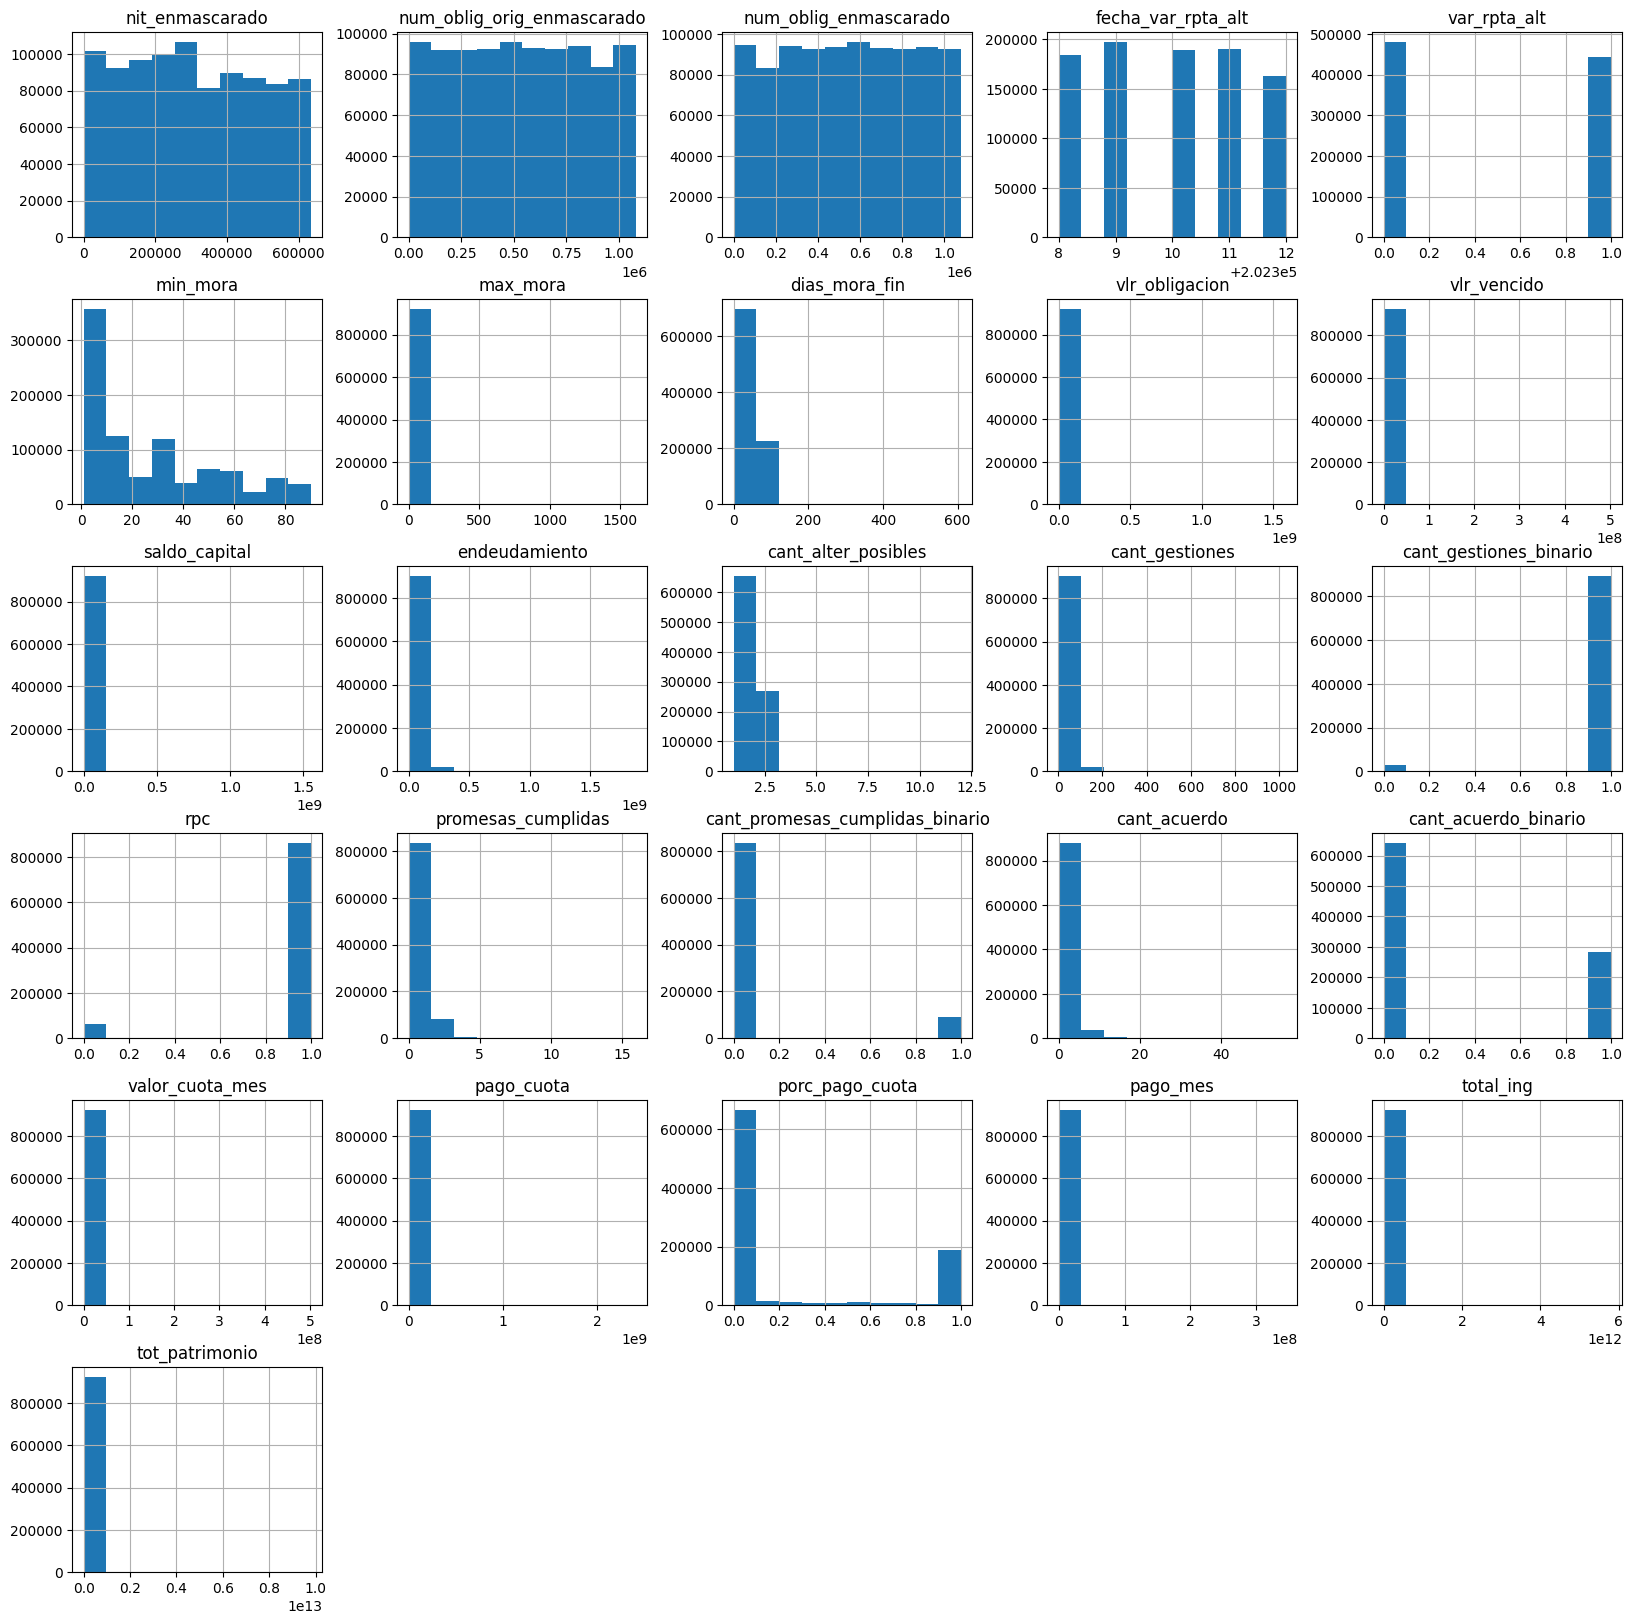

In [7]:
df_resultado.hist(figsize=(20,20))

In [8]:
df_resultado.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,aplicativo,min_mora,max_mora,dias_mora_fin,rango_mora,vlr_obligacion,vlr_vencido,saldo_capital,endeudamiento,desc_alternativa1,desc_alternativa2,desc_alternativa3,cant_alter_posibles,alter_posible1_2,cant_gestiones,cant_gestiones_binario,rpc,promesas_cumplidas,cant_promesas_cumplidas_binario,cant_acuerdo,cant_acuerdo_binario,descripcion_ranking_mejor_ult,descripcion_ranking_post_ult,marca_alt_rank,marca_alt_apli,valor_cuota_mes,pago_cuota,porc_pago_cuota,pago_mes,pagos_tanque,marca_debito_mora,marca_pago,marca_alternativa,marca_alternativa_orig,high_rpc_low_payment,cuartil_deuda,total_ing,tot_patrimonio,moda_marca_pago
0,630611,219718,863073,202308,1,a_uno_tipo_1,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,V,46,71,71,b.31-90,6056996.0,1000259.0,5808115.68,12134572.0,Reestructuración novacion,Sin alivio,Sin alivio,1,CON22,46.0,1,1.0,0,0,0.0,0,ACEPTA ALTERNATIVA,CLIENTE AL DIA,Acepta alternativa,SI,1047805.49,100000.0,0.095438,0.0,Sin pago,NO,Sin pago,Acepta Alternativa,Acepta Alternativa,True,"(4168354.0, 10814241.5]",700000.0,165012.0,NO_PAGO
1,59412,789567,290775,202312,1,a_uno_tipo_1,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,L,16,24,0,a.1-30,9877235.0,443638.0,9451816.00,15479703.0,Prorroga más Ampliación de plazo,Prorroga,Consolidación de pasivos,2,CON02,10.0,1,1.0,0,0,0.0,0,ACEPTA ALTERNATIVA,NO ACEPTA ACUERDO,Acepta alternativa,SI,443837.00,0.0,0.000000,0.0,Sin pago,NO,Sin pago,Acepta Alternativa,Acepta Alternativa,True,"(4168354.0, 10814241.5]",1136000.0,35000000.0,PAGO_MENOS
2,277595,1045909,34433,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,L,36,65,65,b.31-90,79487960.0,7650063.0,75144222.95,95148044.0,Combo modificación,Prórroga modificación,Modificación novacion,3,CON23,50.0,1,0.0,0,0,0.0,0,PLAN DE COMPROMISO CUMPLIDO,ACEPTA ALTERNATIVA,Cliente compromiso de pago,NO,5122226.00,0.0,0.000000,0.0,Sin pago,NO,Sin pago,Acepta Alternativa,Acepta Alternativa,False,"(10814241.5, 1589994069.0]",3561300.0,538318000.0,PAGO_MENOS
3,277595,1045909,34433,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,L,36,65,65,b.31-90,79487960.0,7650063.0,75144222.95,95148044.0,Combo modificación,Prórroga modificación,Modificación novacion,3,CON23,50.0,1,0.0,0,0,0.0,0,PLAN DE COMPROMISO CUMPLIDO,ACEPTA ALTERNATIVA,Cliente compromiso de pago,NO,5122226.00,0.0,0.000000,0.0,Sin pago,NO,Sin pago,Acepta Alternativa,Acepta Alternativa,False,"(10814241.5, 1589994069.0]",9700000.0,538318000.0,PAGO_MENOS
4,26897,585786,494556,202311,1,a_uno_tipo_1,Banca Personas,Personal,ROTATIVOS,Rotativos,L,18,40,0,a.1-30,4022153.0,266898.0,3785620.00,47499162.0,Prorroga más Ampliación de plazo,Prorroga,Consolidación de pasivos,2,CON02,12.0,1,1.0,0,0,4.0,1,PLAN DE PAGO,ACEPTA ALTERNATIVA,Cliente compromiso de pago,SI,266898.00,11241.0,0.042117,4090.0,Con pago,NO,Pago parcial,Acepta Alternativa,Acepta Alternativa,True,"(1577906.5, 4168354.0]",2000000.0,25193977.0,FACTURACION_MES_SGTE


In [6]:

columns_to_drop = [
    'num_oblig_orig_enmascarado', 'fecha_var_rpta_alt', 'tipo_var_rpta_alt',
    'banca', 'segmento', 'producto_cons', 'aplicativo', 'desc_alternativa1',
    'desc_alternativa2', 'desc_alternativa3', 'cant_alter_posibles',
    'alter_posible1_2', 'promesas_cumplidas', 'cant_acuerdo',
    'descripcion_ranking_mejor_ult', 'descripcion_ranking_post_ult',
    'marca_alt_rank', 'marca_alt_apli', 'pago_cuota', 'pago_mes',
    'pagos_tanque', 'marca_pago', 'marca_alternativa', 'marca_alternativa_orig',
    'dias_mora_fin'
]

# Eliminar las columnas
df_resultado = df_resultado.drop(columns=columns_to_drop)

In [14]:
df_resultado.columns

Index(['nit_enmascarado', 'num_oblig_enmascarado', 'var_rpta_alt', 'producto',
       'min_mora', 'max_mora', 'rango_mora', 'vlr_obligacion', 'vlr_vencido',
       'saldo_capital', 'endeudamiento', 'cant_gestiones',
       'cant_gestiones_binario', 'rpc', 'cant_promesas_cumplidas_binario',
       'cant_acuerdo_binario', 'valor_cuota_mes', 'porc_pago_cuota',
       'marca_debito_mora', 'high_rpc_low_payment', 'cuartil_deuda',
       'total_ing', 'tot_patrimonio', 'moda_marca_pago'],
      dtype='object')

# Transformación de variables numeŕicas para modelo

- Las variables numéricas no binarias presentan en algunos casos una kurtosis elevada, lo que indica que los datos requieren una transformación para no verse afectados en gran cantidad por sus ouliers. si bien min_mora y dias_mora fin  no presentan una kurtosis elevada, se realizara una transformación para posterioprmente ser normalilzadas. La transformación seleccionada es la logaritmica que presentó mejores acercam,ioenmtos a la normalización 

In [7]:
# Lista de columnas para transformar
columns_to_transform = ['tot_patrimonio', 'total_ing', 'min_mora', 'max_mora', 'valor_cuota_mes']
df_resultado[columns_to_transform].kurt()


tot_patrimonio     152122.807854
total_ing          398579.273370
min_mora               -0.372721
max_mora               67.536405
valor_cuota_mes      5516.757520
dtype: float64

In [8]:
df_train_final = pd.DataFrame() # Aqui empezamos a colocar los datos transformados para entrenar el modelo

In [9]:

df_transformed = pd.DataFrame()

for column in columns_to_transform:
    df_transformed[f'{column}_log'] = df_resultado[column].apply(lambda x: np.log(x + 1))  # +1 para evitar log(0)

array([[<Axes: title={'center': 'tot_patrimonio_log'}>,
        <Axes: title={'center': 'total_ing_log'}>],
       [<Axes: title={'center': 'min_mora_log'}>,
        <Axes: title={'center': 'max_mora_log'}>],
       [<Axes: title={'center': 'valor_cuota_mes_log'}>, <Axes: >]],
      dtype=object)

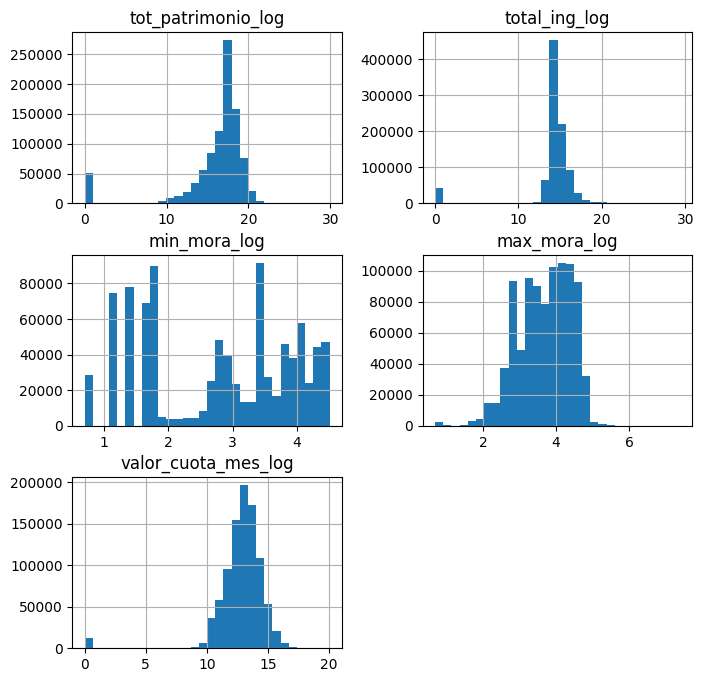

In [12]:
df_transformed.hist(bins=30, figsize=(8,8))

In [13]:
df_transformed.columns

Index(['tot_patrimonio_log', 'total_ing_log', 'min_mora_log', 'max_mora_log',
       'valor_cuota_mes_log'],
      dtype='object')

In [13]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
log_columns = [col for col in df_transformed.columns]
log_columns

['tot_patrimonio_log',
 'total_ing_log',
 'min_mora_log',
 'max_mora_log',
 'valor_cuota_mes_log']

In [15]:
# escalar de 0 a 1
df_transformed[log_columns] = scaler.fit_transform(df_transformed[log_columns])

# Codificación para variables categoricas


Para las variables categóricas del dataset, la recomendación es usar One-Hot Encoding para todas. Aunque algunas variables como rango_mora y marca_debito_mora tienen solo 2 categorías y podrían manejarse con Label Encoding, One-Hot Encoding es preferible para evitar interpretaciones ordinales incorrectas y es adecuado para variables con un número moderado a alto de categorías, como producto y moda_marca_pago. Esta técnica asegura que cada categoría se represente de manera independiente sin introducir relaciones ordinales falsas.

In [16]:
# Describir las columnas categóricas
df_resultado.describe(include='object')

,producto,rango_mora,marca_debito_mora,cuartil_deuda,moda_marca_pago
count,925146,925146,925146,925146,925132
unique,24,2,2,4,7
top,TARJETA DE CREDITO,a.1-30,NO,"(4168354.0, 10814241.5]",PAGO_MAS
freq,396419,611865,852391,231669,387097


In [10]:
from sklearn.preprocessing import OneHotEncoder

# Lista de columnas categóricas a codificar
categorical_columns = [
    'producto', 'rango_mora', 'moda_marca_pago'
]

X_categorical = df_resultado[categorical_columns]
encoder = OneHotEncoder(drop='first',sparse_output=False)
encoded_features = encoder.fit_transform(X_categorical)
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))


In [19]:
encoder.categories_

[array(['CARTERA MICROCREDITO', 'CARTERA ORDINARIA', 'CREDIAGIL',
        'CREDIPAGO', 'CREDITO A LA MANO', 'CREDITO HIPOTECARIO',
        'CREDITOS DE CONSUMO', 'CUENTA CORRIENTE', 'HIPOTECARIO VIVIENDA',
        'LEASING', 'LEASING HABITACIONAL', 'LIBRANZA',
        'LIBRANZA EX EMPLEADOS', 'LIBRE INVERSION', 'MICROCREDITO',
        'OTROS HIPOTECARIO', 'REESTRUCTURADO', 'ROTATIVOS', 'SOBREGIRO',
        'TARJETA DE CREDITO', 'TARJETAS DE CREDITO', 'TESORERIA',
        'Titularizada', 'VENTA DIGITAL'], dtype=object),
 array(['a.1-30', 'b.31-90'], dtype=object),
 array(['AJUSTES_BANCO', 'CANCELADO', 'FACTURACION_MES_SGTE', 'IGUAL',
        'NO_PAGO', 'PAGO_MAS', 'PAGO_MENOS', nan], dtype=object)]

In [25]:
scaler.feature_names_in_

array(['tot_patrimonio_log', 'total_ing_log', 'min_mora_log',
       'max_mora_log', 'valor_cuota_mes_log'], dtype=object)

In [26]:
df_resultado['rango_mora'].unique()

array(['b.31-90', 'a.1-30'], dtype=object)

In [27]:
log_columns

['tot_patrimonio_log',
 'total_ing_log',
 'min_mora_log',
 'max_mora_log',
 'valor_cuota_mes_log']

In [28]:
df_mod_existentes.columns

Index(['nit_enmascarado', 'num_oblig_enmascarado', 'prob_propension',
       'prob_alrt_temprana', 'prob_auto_cura'],
      dtype='object')

In [14]:
df_train_final[['nit_enmascarado', 'num_oblig_enmascarado']] = df_resultado[['nit_enmascarado', 'num_oblig_enmascarado']]
#df_train_final[log_columns]=scaler.transform(df_transformed[log_columns])
df_train_final[log_columns]=df_transformed[log_columns]
df_train_final['var_rpta_alt']=df_resultado['var_rpta_alt']

#df_train_final = pd.merge(
#    df_train_final, 
#    df_mod_existentes, 
#    on=['nit_enmascarado', 'num_oblig_enmascarado'], 
#    how='left'
#)
df_train_final = pd.concat([
    df_train_final,
    encoded_df
], axis=1)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X = df_train_final.drop(['nit_enmascarado', 'num_oblig_enmascarado', 'var_rpta_alt'], axis=1)
y = df_train_final['var_rpta_alt']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imprimir las formas de los conjuntos resultantes
print("Forma de X_train:", X_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)

X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

Forma de X_train: (740116, 36)
Forma de X_test: (185030, 36)
Forma de y_train: (740116,)
Forma de y_test: (185030,)


In [17]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


In [18]:

# Estos reemplazos son necesarios para xgboost
X_train.columns = X_train.columns.str.replace('[\[\]\(\)]', '', regex=True)
X_test.columns = X_test.columns.str.replace('[\[\]\(\)]', '', regex=True)

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGboost': XGBClassifier(),
}

f1_scores = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='binary')
    f1_scores[model_name] = f1
    print(f'{model_name}: F1 Score = {f1}')

best_model_name = max(f1_scores, key=f1_scores.get)
print(f'Best Model: {best_model_name} with F1 Score = {f1_scores[best_model_name]}')


/home/lean/miniconda3/envs/mlops_course/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: F1 Score = 0.6609179231698638
Random Forest: F1 Score = 0.8982123228232571
Decision Tree: F1 Score = 0.8743681863927449
XGboost: F1 Score = 0.7827346869048598
Best Model: Random Forest with F1 Score = 0.8982123228232571


In [27]:
df_evaluation = pd.read_csv('files/prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv')

df_evaluation.head()

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt
0,257335,444821,635511,202401
1,59584,350400,730364,202401
2,397604,973821,106521,202401
3,368086,382995,696856,202401
4,255009,434238,645924,202401


In [23]:
X_train=pd.read_csv('X_train.csv')
y_train=pd.read_csv('y_train.csv')
X_test=pd.read_csv('X_test.csv')
y_test=pd.read_csv('y_test.csv')

model_eval = RandomForestClassifier(max_depth=None, n_estimators=100, random_state=42)
model_eval.fit(X_train, y_train)
y_pred = model_eval.predict(X_test)
f1 = f1_score(y_test, y_pred, average='binary')
print(f'F1 Score = {f1}')

/home/lean/miniconda3/envs/mlops_course/lib/python3.9/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


F1 Score = 0.897868473901393


In [16]:
model_eval2 = RandomForestClassifier(
    n_estimators=300,        # Aumentado ligeramente de 100
    max_depth=None,            # Limitamos la profundidad para evitar sobreajuste
    max_features='sqrt',     # Mantenemos 'sqrt'
    min_samples_split=4,     # Aumentado ligeramente de 2
    min_samples_leaf=2,      # Aumentado ligeramente de 1
    bootstrap=True,          # Mantenemos True
    random_state=42          # Añadimos para reproducibilidad
)
#model_eval2 = RandomForestClassifier()
model_eval2.fit(X_train, y_train)
y_pred = model_eval2.predict(X_test)
f1 = f1_score(y_test, y_pred, average='binary')
print(f'F1 Score = {f1}')

F1 Score = 0.8809418325092889


In [6]:
model_eval.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [31]:
X_train.columns

Index(['tot_patrimonio_log', 'total_ing_log', 'min_mora_log', 'max_mora_log',
       'valor_cuota_mes_log', 'producto_CARTERA ORDINARIA',
       'producto_CREDIAGIL', 'producto_CREDIPAGO',
       'producto_CREDITO A LA MANO', 'producto_CREDITO HIPOTECARIO',
       'producto_CREDITOS DE CONSUMO', 'producto_CUENTA CORRIENTE',
       'producto_HIPOTECARIO VIVIENDA', 'producto_LEASING',
       'producto_LEASING HABITACIONAL', 'producto_LIBRANZA',
       'producto_LIBRANZA EX EMPLEADOS', 'producto_LIBRE INVERSION',
       'producto_MICROCREDITO', 'producto_OTROS HIPOTECARIO',
       'producto_REESTRUCTURADO', 'producto_ROTATIVOS', 'producto_SOBREGIRO',
       'producto_TARJETA DE CREDITO', 'producto_TARJETAS DE CREDITO',
       'producto_TESORERIA', 'producto_Titularizada', 'producto_VENTA DIGITAL',
       'rango_mora_b.31-90', 'moda_marca_pago_CANCELADO',
       'moda_marca_pago_FACTURACION_MES_SGTE', 'moda_marca_pago_IGUAL',
       'moda_marca_pago_NO_PAGO', 'moda_marca_pago_PAGO_MAS',
  

In [19]:
def log_trans(valor):
    return np.log(valor+1)

def normalize_values(valor):
    return scaler.transform(valor)

In [20]:
def ohe_features(values):

    return encoder.transform(values)

In [39]:
X_train.columns

Index(['tot_patrimonio_log', 'total_ing_log', 'min_mora_log', 'max_mora_log',
       'valor_cuota_mes_log', 'producto_CARTERA ORDINARIA',
       'producto_CREDIAGIL', 'producto_CREDIPAGO',
       'producto_CREDITO A LA MANO', 'producto_CREDITO HIPOTECARIO',
       'producto_CREDITOS DE CONSUMO', 'producto_CUENTA CORRIENTE',
       'producto_HIPOTECARIO VIVIENDA', 'producto_LEASING',
       'producto_LEASING HABITACIONAL', 'producto_LIBRANZA',
       'producto_LIBRANZA EX EMPLEADOS', 'producto_LIBRE INVERSION',
       'producto_MICROCREDITO', 'producto_OTROS HIPOTECARIO',
       'producto_REESTRUCTURADO', 'producto_ROTATIVOS', 'producto_SOBREGIRO',
       'producto_TARJETA DE CREDITO', 'producto_TARJETAS DE CREDITO',
       'producto_TESORERIA', 'producto_Titularizada', 'producto_VENTA DIGITAL',
       'rango_mora_b.31-90', 'moda_marca_pago_CANCELADO',
       'moda_marca_pago_FACTURACION_MES_SGTE', 'moda_marca_pago_IGUAL',
       'moda_marca_pago_NO_PAGO', 'moda_marca_pago_PAGO_MAS',
  

In [28]:
import warnings
from tqdm import tqdm

warnings.filterwarnings('ignore')
output_file = 'sample_submission_5.csv'
unknown_count = 0
predict_columns_names = X_train.columns

# Función para verificar si un valor está vacío o es NaN
def is_empty_or_nan(value):
    if isinstance(value, (pd.Series, pd.DataFrame)):
        return value.empty
    return pd.isna(value) or value is None

with open(output_file, 'w') as f:
    f.write('ID,var_rpta_alt\n')


    for _, row in tqdm(df_evaluation.iterrows(), total=len(df_evaluation), desc="Procesando"):
        nit_enmascarado = row['nit_enmascarado']
        num_oblig_orig_enmascarado = row['num_oblig_orig_enmascarado']
        num_oblig_enmascarado = row['num_oblig_enmascarado']

        # Obtener datos
        tot_patrimonio = df_demografico['tot_patrimonio'][(df_demografico['nit_enmascarado'] == nit_enmascarado)].median()
        total_ing = df_demografico['total_ing'][(df_demografico['nit_enmascarado'] == nit_enmascarado)].median()
        min_mora = df_historic['dias_mora'][(df_historic['nit_enmascarado'] == nit_enmascarado) & (df_historic['num_oblig_enmascarado'] == num_oblig_enmascarado)].min()
        max_mora = df_historic['dias_mora'][(df_historic['nit_enmascarado'] == nit_enmascarado) & (df_historic['num_oblig_enmascarado'] == num_oblig_enmascarado)].max()
        valor_cuota_mes = df_historic['valor_cuota_mes'][(df_historic['nit_enmascarado'] == nit_enmascarado) & (df_historic['num_oblig_enmascarado'] == num_oblig_enmascarado)].median()
        producto = df_historic['producto'][(df_historic['nit_enmascarado'] == nit_enmascarado) & (df_historic['num_oblig_enmascarado'] == num_oblig_enmascarado)].mode()
        moda_marca_pago = df_historic['marca_pago'][(df_historic['nit_enmascarado'] == nit_enmascarado) & (df_historic['num_oblig_enmascarado'] == num_oblig_enmascarado)].mode()

        # Verificar si algún dato está vacío
        if (is_empty_or_nan(tot_patrimonio) or is_empty_or_nan(total_ing) or 
            is_empty_or_nan(min_mora) or is_empty_or_nan(max_mora) or 
            is_empty_or_nan(valor_cuota_mes) or producto.empty or moda_marca_pago.empty):
            prediction = 1
            unknown_count += 1

        else:
            # Realizar transformaciones y predicción
            tot_patrimonio_log = log_trans(tot_patrimonio)
            total_ing_log = log_trans(total_ing)
            min_mora_log = log_trans(min_mora)
            max_mora_log = log_trans(max_mora)
            valor_cuota_mes_log = log_trans(valor_cuota_mes)
            numeric_features = [tot_patrimonio_log, total_ing_log, min_mora_log, max_mora_log, valor_cuota_mes_log]
            numeric_features_scaled = normalize_values([numeric_features])[0]

            producto = producto.iloc[0]
            moda_marca_pago = moda_marca_pago.iloc[0]
            rango_mora_log = 'a.1-30' if max_mora <= 30 else 'b.31-90'

            encoded_features = ohe_features([[producto, rango_mora_log, moda_marca_pago]])
            data = list(numeric_features_scaled) + list(encoded_features[0])
            df_predict = pd.DataFrame([data], columns=predict_columns_names)
            prediction = model_eval.predict(df_predict)[0]

        f.write(f'{nit_enmascarado}#{num_oblig_orig_enmascarado}#{num_oblig_enmascarado},{prediction}\n')

print(f'Total de predicciones sin data encontrada en ningun archivo: {unknown_count}')

Procesando:   0%|          | 0/112549 [00:00<?, ?it/s]

Procesando: 100%|██████████| 112549/112549 [2:19:26<00:00, 13.45it/s] 

Total de predicciones sin data encontrada en ningun archivo: 22241
